<a href="https://colab.research.google.com/github/BragdonD/text-classification-NLP-tf/blob/main/Multiclass_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the depencies

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import Dataset
from tensorflow.keras import regularizers
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.utils import class_weight

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import string
import spacy
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


Mouting the drive and defining the path toward the dataset file

In [ ]:
from google.colab import drive
import json

drive.mount("/content/drive/")

Mounted at /content/drive/


Extract the data from the Json file and turn it into a panda DataFrame

In [ ]:
def load_csv_dataset(path):
    """Function to load a dataset from a csv file

    Args:
        path (str): relative path to the csv file

    Returns:
        pd.DataFrame: the dataframe load
    """
    return pd.read_csv(path)

In [ ]:
FILE_PATH = "drive/MyDrive/NLP/" + "train_40k.csv";

In [ ]:
df = load_csv_dataset(FILE_PATH);

In [ ]:
df.head()

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,B000GRA6N8,Westing Game,unknown,0/0,5.0,897696000,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,B00000DMDQ,I SPY A is For Jigsaw Puzzle 63pc,unknown,2/4,5.0,911865600,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles


In [ ]:
df = df.drop("productId", axis=1)
df = df.drop("Title", axis=1)
df = df.drop("userId", axis=1)
df = df.drop("Helpfulness", axis=1)
df = df.drop("Score", axis=1)
df = df.drop("Time", axis=1)
df = df.drop("Cat2", axis=1)
df = df.drop("Cat3", axis=1)
df = df.rename(columns={"Text": "description", "Cat1": "label"})

Text Preprocessing

In [ ]:
lemmatizer = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
stemmer = nltk.SnowballStemmer("english")
remove_symbols = re.compile('[-+/(){}\[\]\|@,;]')
remove_numbers = re.compile('[0-9] {,1}')
PUNCTUATION = string.punctuation
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


In [ ]:
def lemmatize_sentence(sentence):
    """Function to lemmatize a sentence

    Args:
        sentence (str): the string to lemmatize

    Returns:
        str: the lemmatized string
    """
    doc = lemmatizer(sentence)
    return " ".join([token.lemma_ for token in doc])

def text_preprocess(sentence):
    """Function to preprocess a sentence to remove punctuation, emoji, symbols and to lemmatize

    Args:
        sentence (str): sentence to be preprocess

    Returns:
        str: the new sentence
    """
    if isinstance(sentence, str):
        sentence = sentence.lower() ## Make the text lower case
        sentence = sentence.translate(str.maketrans('', '', PUNCTUATION)) ## Remove the punctuation
        sentence = emoji_pattern.sub(' ', sentence)
        sentence = remove_symbols.sub(' ', sentence)
        sentence = remove_numbers.sub(' ', sentence)
        sentence = lemmatize_sentence(sentence)
        return sentence
    Exception("sentence need to be a string.")

In [ ]:
tqdm.pandas() ## To display a progress bar
df.description = df.description.progress_apply(lambda text : text_preprocess(text))

100%|██████████| 40000/40000 [05:35<00:00, 119.27it/s]


In [ ]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(df.label.values),
                                                  y = df.label.values)

In [ ]:
class_weights = dict(zip(np.unique([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]), class_weights))
class_weights

{0: 1.182662172550411,
 1: 1.1403808872163304,
 2: 1.84314809694959,
 3: 0.6822213125938055,
 4: 1.3711778417660772,
 5: 0.6493928177154361}

In [ ]:
encoder = LabelBinarizer()
df_cat_enc = encoder.fit_transform(df.label.values);
df["label"] = df_cat_enc.tolist()

In [ ]:
df.head()

,description,label
0,the description and photo on this product need...,"[0, 0, 1, 0, 0, 0]"
1,this be a great book it be well think through ...,"[0, 0, 0, 0, 0, 1]"
2,I be a first year teacher teach th grade I h...,"[0, 0, 0, 0, 0, 1]"
3,I get the book at my bookfair at school look f...,"[0, 0, 0, 0, 0, 1]"
4,hi I m martine redman and I create this puzzle...,"[0, 0, 0, 0, 0, 1]"


In [ ]:
train, test = train_test_split(df, test_size=0.2, shuffle=True, stratify=df.label)
train, validation = train_test_split(train, test_size=0.4, shuffle=True, stratify=train.label)

In [ ]:
print(train["label"].value_counts(normalize=True))

[0, 0, 0, 0, 0, 1]    0.256667
[0, 0, 0, 1, 0, 0]    0.244271
[0, 1, 0, 0, 0, 0]    0.146146
[1, 0, 0, 0, 0, 0]    0.140937
[0, 0, 0, 0, 1, 0]    0.121563
[0, 0, 1, 0, 0, 0]    0.090417
Name: label, dtype: float64


In [ ]:
print(test["label"].value_counts(normalize=True))

[0, 0, 0, 0, 0, 1]    0.256625
[0, 0, 0, 1, 0, 0]    0.244375
[0, 1, 0, 0, 0, 0]    0.146125
[1, 0, 0, 0, 0, 0]    0.141000
[0, 0, 0, 0, 1, 0]    0.121500
[0, 0, 1, 0, 0, 0]    0.090375
Name: label, dtype: float64


In [ ]:
print(validation["label"].value_counts(normalize=True))

[0, 0, 0, 0, 0, 1]    0.256641
[0, 0, 0, 1, 0, 0]    0.244297
[0, 1, 0, 0, 0, 0]    0.146172
[1, 0, 0, 0, 0, 0]    0.140859
[0, 0, 0, 0, 1, 0]    0.121563
[0, 0, 1, 0, 0, 0]    0.090469
Name: label, dtype: float64


In [ ]:
train_ds = Dataset.from_tensor_slices((train.description, train.label.tolist()));
validation_ds = Dataset.from_tensor_slices((validation.description, validation.label.tolist()));
test_ds = Dataset.from_tensor_slices((test.description, test.label.tolist()));

In [ ]:
BATCH_SIZE = 16

train_ds = train_ds.shuffle(100000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.shuffle(70000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
encoder.classes_

array(['baby products', 'beauty', 'grocery gourmet food',
       'health personal care', 'pet supplies', 'toys games'], dtype='<U20')

In [ ]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = [i for i, elem in enumerate(encoded_labels) if elem == 1]
    return np.take(encoder.classes_, hot_indices)[0]

In [ ]:
for example, label in train_ds.take(1):
  print('text: ', example.numpy()[0])
  print('label: ', invert_multi_hot(label.numpy()[0]))


text:  b'this be a confident well balanced and sexy cologne I wear this for a a fun night out the kind where you undo one extra shirt button I definitely get complement on this one'
label:  beauty


In [ ]:
for example, label in train_ds.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'what else can I say the sea turtle have a good home and be love by a little girl a great toy and well make'
 b'I get this for my daughter   st birthday and she love it she love make the sink play the song and put the pan on the stove to make the noise and light its hold up a ton to my daughter bang tipping and pull the fridge door do come off but its simple to put right back on and do not pose any kind of danger so I do not see why that would be a complaint I love this kitchen until now I have not find a toy that will occupy she for so long she love try to open everything so it also satisfy she want to do that'
 b'I have look up the ingredient and there be zero wasabi in this producthorseradish be the number one ingredienthorseradish wasabi be wasabi not wasabi if you ve only eat sushi with wasabi paste you ve probably never have the real thing'
 b'my boy love this toy and it do come with a few refill balloon after they be go so be the toy I could not find a balloon big enoug

In [ ]:
MAX_WORDS = 20000
MAX_LEN = 11 # 50% of the dataset have an average length of 11 words
vector = tf.keras.layers.TextVectorization(
    max_tokens=MAX_WORDS,
    standardize=None,
    ngrams=1
  )
vector.adapt(train_ds.map(lambda text, label: text))

In [ ]:
embeddings_index = dict()
path_to_glove_embed = "drive/MyDrive/NLP/glove.6B.100d.txt"
def get_embeddings_from_glove(glove_path):
  embeddings_index = dict();
  for line in open(glove_path, encoding="utf8"):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  return embeddings_index;

embeddings_index = get_embeddings_from_glove(path_to_glove_embed);

In [ ]:
def get_embedding_matrix():
  embedding_matrix = np.zeros((len(vector.get_vocabulary()), 100))
  for word, i in zip(vector.get_vocabulary(),range(len(vector.get_vocabulary()))):
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  return embedding_matrix

embedding_matrix = get_embedding_matrix()

In [ ]:
vocab = np.array(vector.get_vocabulary())
print(len(vocab))
vocab[:20]

20000


array(['', '[UNK]', 'the', 'be', 'I', 'and', 'it', 'to', 'a', 'this',
       'have', 'of', 'not', 'for', 'my', 'in', 'that', 'do', 'with',
       'they'], dtype='<U61')

Splitting the dataset between train, validation and test

In [ ]:
# model = Sequential([
#     Dense(524, activation='relu'),
#     Dense(262, activation='relu'),
#     Dense(Y.shape[1], activation='sigmoid')
# ])

In [ ]:
# model = Sequential([
#     vector,
#     Embedding(len(vocab), EMBEDDING_DIM, mask_zero=True),
#     GRU(EMBEDDING_DIM, return_sequences=True),
#     GRU(int(EMBEDDING_DIM/2)),
#     Dense(int(EMBEDDING_DIM/2), activation='relu'),
#     Dropout(0.3),
#     Dense(len(encoder.classes_), activation='sigmoid')
# ])


In [ ]:
# model = Sequential([
#     vector,
#     Embedding(MAX_NB_WORDS, EMBEDDING_DIM, mask_zero=True),
#     Conv1D(128, 5, activation='relu'),
#     GlobalMaxPooling1D(),
#     Dense(28, activation='relu'),
#     Dropout(0.2),
#     Dense(len(encoder.classes_))
# ])


In [ ]:
model = Sequential([
    vector,
    Embedding( 
        input_dim=len(vocab), 
        output_dim=100,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),  
    SpatialDropout1D(0.2),
    GRU(64, dropout=0.2, return_sequences=True),  
    GRU(64, dropout=0.2, return_sequences=True),
    GRU(64, dropout=0.2),
    Dropout(0.3),
    Dense(len(encoder.classes_), activation="softmax")
])


In [ ]:
print([layer.supports_masking for layer in model.layers])


[False, False, True, True, True, True, True, True]


In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 832ms/step
[0.12107162 0.21784987 0.17677791 0.16986741 0.14249097 0.17194216]


In [ ]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 88ms/step
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(  loss='categorical_crossentropy', 
                optimizer='adam', 
                weighted_metrics=['acc',f1_m,precision_m, recall_m])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         2000000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, None, 100)        0         
 lDropout1D)                                                     
                                                                 
 gru_7 (GRU)                 (None, None, 64)          31872     
                                                                 
 gru_8 (GRU)                 (None, None, 64)          24960     
                                                                 
 gru_9 (GRU)                 (None, 64)               

In [ ]:
epochs = 20

history = model.fit(
    train_ds, 
    epochs=epochs,
    validation_data=validation_ds,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
    ]
)

Epoch 1/20
1200/1200 [==============================] - 38s 27ms/step - loss: 0.9956 - acc: 0.6414 - f1_m: 0.5501 - precision_m: 0.7359 - recall_m: 0.4507 - val_loss: 0.7907 - val_acc: 0.7291 - val_f1_m: 0.7204 - val_precision_m: 0.7752 - val_recall_m: 0.6759
Epoch 2/20
1200/1200 [==============================] - 32s 27ms/step - loss: 0.7918 - acc: 0.7263 - f1_m: 0.6839 - precision_m: 0.7826 - recall_m: 0.6124 - val_loss: 0.7518 - val_acc: 0.7398 - val_f1_m: 0.7148 - val_precision_m: 0.8113 - val_recall_m: 0.6438
Epoch 3/20
1200/1200 [==============================] - 32s 27ms/step - loss: 0.7110 - acc: 0.7566 - f1_m: 0.7244 - precision_m: 0.8075 - recall_m: 0.6614 - val_loss: 0.6555 - val_acc: 0.7729 - val_f1_m: 0.7666 - val_precision_m: 0.8292 - val_recall_m: 0.7162
Epoch 4/20
1200/1200 [==============================] - 32s 27ms/step - loss: 0.6707 - acc: 0.7664 - f1_m: 0.7392 - precision_m: 0.8184 - recall_m: 0.6782 - val_loss: 0.6379 - val_acc: 0.7805 - val_f1_m: 0.7742 - val_pre

In [ ]:
accr = model.evaluate(test_ds)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

500/500 [==============================] - 6s 11ms/step - loss: 0.5525 - acc: 0.8106 - f1_m: 0.8060 - precision_m: 0.8633 - recall_m: 0.7591
Test set
  Loss: 0.553
  Accuracy: 0.811


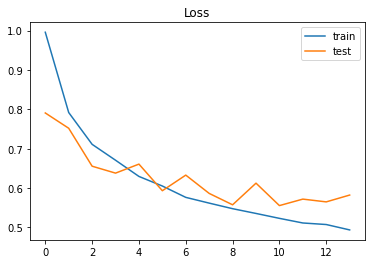

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

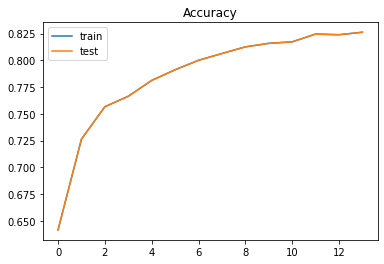

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['acc'], label='test')
plt.legend()
plt.show();

In [ ]:
checkpoint_path = "drive/MyDrive/NLP/training_6/cp-{epoch:04d}.ckpt"
model.save_weights(checkpoint_path.format(epoch=0))